<a href="https://colab.research.google.com/github/haokeliu/colaboratory/blob/master/DeepLearn_Notes/%E5%A4%9A%E5%B1%82%E6%84%9F%E7%9F%A5_Multilayer_Perceptron_(MLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**数据Data**

我们将为分类任务生产一些非线性数据

In [1]:
# Load PyTorch library
!pip3 install torch torchvision

In [0]:
from argparse import Namespace
import matplotlib.pylab as plt
import numpy as np
import random
import torch

Argparse的作用就是为py文件封装好可以选择的参数，使他们更加灵活，丰富。

In [0]:
# Arguments
args = Namespace(
    seed = 1234,
    num_samples_per_class = 500,
    dimensions = 2, # n.	维
    num_classes = 3,
    train_size = 0.75,
    test_size = 0.25,
    num_hidden_units = 100,
    learning_rate = 1e-0,
    regularization = 1e-3,
    num_epochs = 200,
)
# Set seed for reproducability
np.random.seed(args.seed)

In [0]:
# Generate non-linear data
def generate_data(num_samples_per_class, dimensions, num_classes):
    # Make synthetic spiral data
    X_original = np.zeros((num_samples_per_class*num_classes, dimensions))
    y = np.zeros(num_samples_per_class*num_classes, dtype='uint8')
    for j in range(num_classes):
        ix = range(num_samples_per_class*j,num_samples_per_class*(j+1))
        r = np.linspace(0.0,1,num_samples_per_class) # radius
        t = np.linspace(j*4,(j+1)*4,num_samples_per_class) + \
        np.random.randn(num_samples_per_class)*0.2 # theta
        X_original[ix] = np.c_[r*np.sin(t), r*np.cos(t)] # 随机点 横坐标sin x 纵坐标 cos x
        y[ix] = j # 类别标签 j

    # Stack
    X = np.hstack([X_original])
#     两个拼接数组的方法：
#     np.vstack():在竖直方向上堆叠
#     np.hstack():在水平方向上平铺
    return X, y

In [12]:
# Generate X & y
X, y = generate_data(num_samples_per_class=args.num_samples_per_class, 
                     dimensions=args.dimensions, num_classes=args.num_classes)
print ("X: {0}".format(np.shape(X)))
print ("y: {0}".format(np.shape(y)))

X: (1500, 2)
y: (1500,)


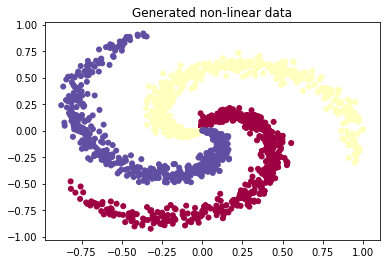

In [13]:
#scatter散点图
plt.title("Generated non-linear data")
plt.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap=plt.cm.Spectral)
plt.show()

In [0]:
# Convert to PyTorch tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

In [25]:
# Shuffle data
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(a)), len(a)))
#random.sample()可以从指定的序列中，随机的截取指定长度的片断，不作原地修改。
X = X[shuffle_indicies]
y = y[shuffle_indicies]
# Split datasets
test_start_idx = int(len(X)*args.train_size)
x_train = X[:test_start_idx]
y_train = y[:test_start_idx]
x_test = X[test_start_idx]
y_test = y[test_start_idx]
print("We have %i train samples and %i test samples." % (len(x_train), len(x_test)))

We have 3 train samples and 2 test samples.


**线性模型 Linear model**
在使用神经网络之前，我们先用 PyTorch 的线性模型（逻辑回归）试一下。我们想看看为什么线性模型不能满足数据要求。

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm_notebook

In [0]:
# Linear model
class LogisticClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LogisticClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        a_1 = self.fc1(x_in)
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [34]:
# Initialize model
model = LogisticClassifier(input_dim=args.dimensions, 
                           hidden_dim=args.num_hidden_units, 
                           output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of LogisticClassifier(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [0]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = args.learning_rate)
## Adam optimizer (usually better than SGD)

In [0]:
# Accuracy
def get_accuracy(y_pred,y_target):
  n_correct = torch.eq(y_pred,y_target).sum().item()
  accuracy = n_correct /len(y_pred)*100
  return accuracy